In [156]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils.utils import *
import math
from utils import *
import seaborn as sns
from scipy import stats

In [157]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
edau = EDAUtils()
statsu = StatsUtils()

In [159]:
# Set up paths
script_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
tableu_dir = os.path.join(root_dir, 'tableau')
porcessed_data_dir = os.path.join(script_dir, 'processed_data')

In [160]:
k = 4
eps = 1.5 
n_rows = 1000
# Load labeled data
labeled_scenarios_df = pd.read_csv(os.path.join(porcessed_data_dir, f'bardis_ensemble_python_ver_{n_rows}_k{k}_eps{eps}.csv'))
labeled_scenarios_df

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.000000,0.100000,1.000000e-02,0.001000,0.0,1.0,2,0
1,0.999887,0.100171,1.003014e-02,0.001246,0.2,1.0,2,0
2,0.999773,0.100343,1.006030e-02,0.001492,0.4,1.0,2,0
3,0.999658,0.100516,1.009050e-02,0.001739,0.6,1.0,2,0
4,0.999541,0.100689,1.012073e-02,0.001986,0.8,1.0,2,0
...,...,...,...,...,...,...,...,...
1000995,0.004725,0.033576,1.231674e-09,1.137058,199.2,1000.0,0,1
1000996,0.004726,0.033576,1.190023e-09,1.137058,199.4,1000.0,0,1
1000997,0.004727,0.033576,1.149781e-09,1.137059,199.6,1000.0,0,1
1000998,0.004728,0.033576,1.110899e-09,1.137059,199.8,1000.0,0,1


In [161]:
# Create a test subset of the data
test_df = labeled_scenarios_df[labeled_scenarios_df['run_id'] < 6].copy()
test_df

,Resources,Economy,Bureaucracy,Pollution,time,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.000000,0.100000,0.010000,0.001000,0.0,1.0,2,0
1,0.999887,0.100171,0.010030,0.001246,0.2,1.0,2,0
2,0.999773,0.100343,0.010060,0.001492,0.4,1.0,2,0
3,0.999658,0.100516,0.010091,0.001739,0.6,1.0,2,0
4,0.999541,0.100689,0.010121,0.001986,0.8,1.0,2,0
...,...,...,...,...,...,...,...,...
5000,0.598700,0.254535,0.000033,0.451973,199.2,5.0,2,0
5001,0.598440,0.254536,0.000033,0.452381,199.4,5.0,2,0
5002,0.598181,0.254536,0.000032,0.452789,199.6,5.0,2,0
5003,0.597922,0.254537,0.000032,0.453196,199.8,5.0,2,0


## Label Experimental Design and EDA

In [162]:
# Load exp_design data
exp_design_df = pd.read_csv(os.path.join(tableu_dir, f'exp_design_python_ver_{n_rows}.csv'))
exp_design_df.head()

,k_resources:X,ef_economy_resources_on_prod:X,ef_bureaucracy_on_prod:X,k_deprec:X,ef_pollution_on_depreciation:X,k_bureaucracy:X,ef_economy_on_bureaucracy:X,k_decay_bureaucracy:X,ef_pollution_on_bureaucracy:X,k_pollution:X,k_pollution_decay:X,run_id
0,1.392903,0.740275,1.107167,1.467125,1.439415,0.890065,0.682737,1.156487,0.620773,1.276332,0.699204,1
1,0.712712,1.433873,1.264185,0.896099,0.974583,1.099650,1.447798,0.581110,1.020272,1.439854,1.142763,2
2,0.875120,1.345098,0.690112,1.081365,1.193424,1.277574,0.848881,0.992519,0.964165,0.973668,0.870030,3
3,1.323398,1.073804,1.060354,0.854320,1.310371,1.123683,1.350871,1.234065,0.911652,0.805283,0.728287,4
4,1.033195,0.695342,0.630969,1.306555,1.080865,0.559529,0.540256,1.228741,1.456198,1.390584,0.502935,5


In [163]:
# Create a df that has the unique run ids and the corresponding cluster id
runs_cluster_mapping = labeled_scenarios_df.groupby('run_id')[['kmeans_cluster_id', 'dbscan_cluster_id']].first().reset_index()
runs_cluster_mapping

,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.0,2,0
1,2.0,0,1
2,3.0,1,1
3,4.0,0,1
4,5.0,2,0
...,...,...,...
995,996.0,0,1
996,997.0,0,1
997,998.0,3,3
998,999.0,1,1


In [164]:
# Merge the exp_design_df with the runs_cluster_mapping to get the cluster ids for each run
exp_design_df = pd.merge(exp_design_df, runs_cluster_mapping, on='run_id', how='left')
exp_design_df

,k_resources:X,ef_economy_resources_on_prod:X,ef_bureaucracy_on_prod:X,k_deprec:X,ef_pollution_on_depreciation:X,k_bureaucracy:X,ef_economy_on_bureaucracy:X,k_decay_bureaucracy:X,ef_pollution_on_bureaucracy:X,k_pollution:X,k_pollution_decay:X,run_id,kmeans_cluster_id,dbscan_cluster_id
0,1.392903,0.740275,1.107167,1.467125,1.439415,0.890065,0.682737,1.156487,0.620773,1.276332,0.699204,1,2,0
1,0.712712,1.433873,1.264185,0.896099,0.974583,1.099650,1.447798,0.581110,1.020272,1.439854,1.142763,2,0,1
2,0.875120,1.345098,0.690112,1.081365,1.193424,1.277574,0.848881,0.992519,0.964165,0.973668,0.870030,3,1,1
3,1.323398,1.073804,1.060354,0.854320,1.310371,1.123683,1.350871,1.234065,0.911652,0.805283,0.728287,4,0,1
4,1.033195,0.695342,0.630969,1.306555,1.080865,0.559529,0.540256,1.228741,1.456198,1.390584,0.502935,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.338679,0.948047,0.863291,0.516011,0.975849,0.918143,1.494500,1.226192,0.692881,1.359333,1.121035,996,0,1
996,1.166177,1.447584,1.140197,1.410452,1.009813,1.069964,1.401187,1.231764,1.052078,0.775911,0.723906,997,0,1
997,1.332151,0.721352,0.535175,0.772054,1.388809,1.328604,0.862685,0.896585,1.321625,1.171241,1.447865,998,3,3
998,0.548349,0.568214,1.405391,0.651543,0.900097,1.237380,1.428046,1.184118,1.475893,0.971249,0.625352,999,1,1


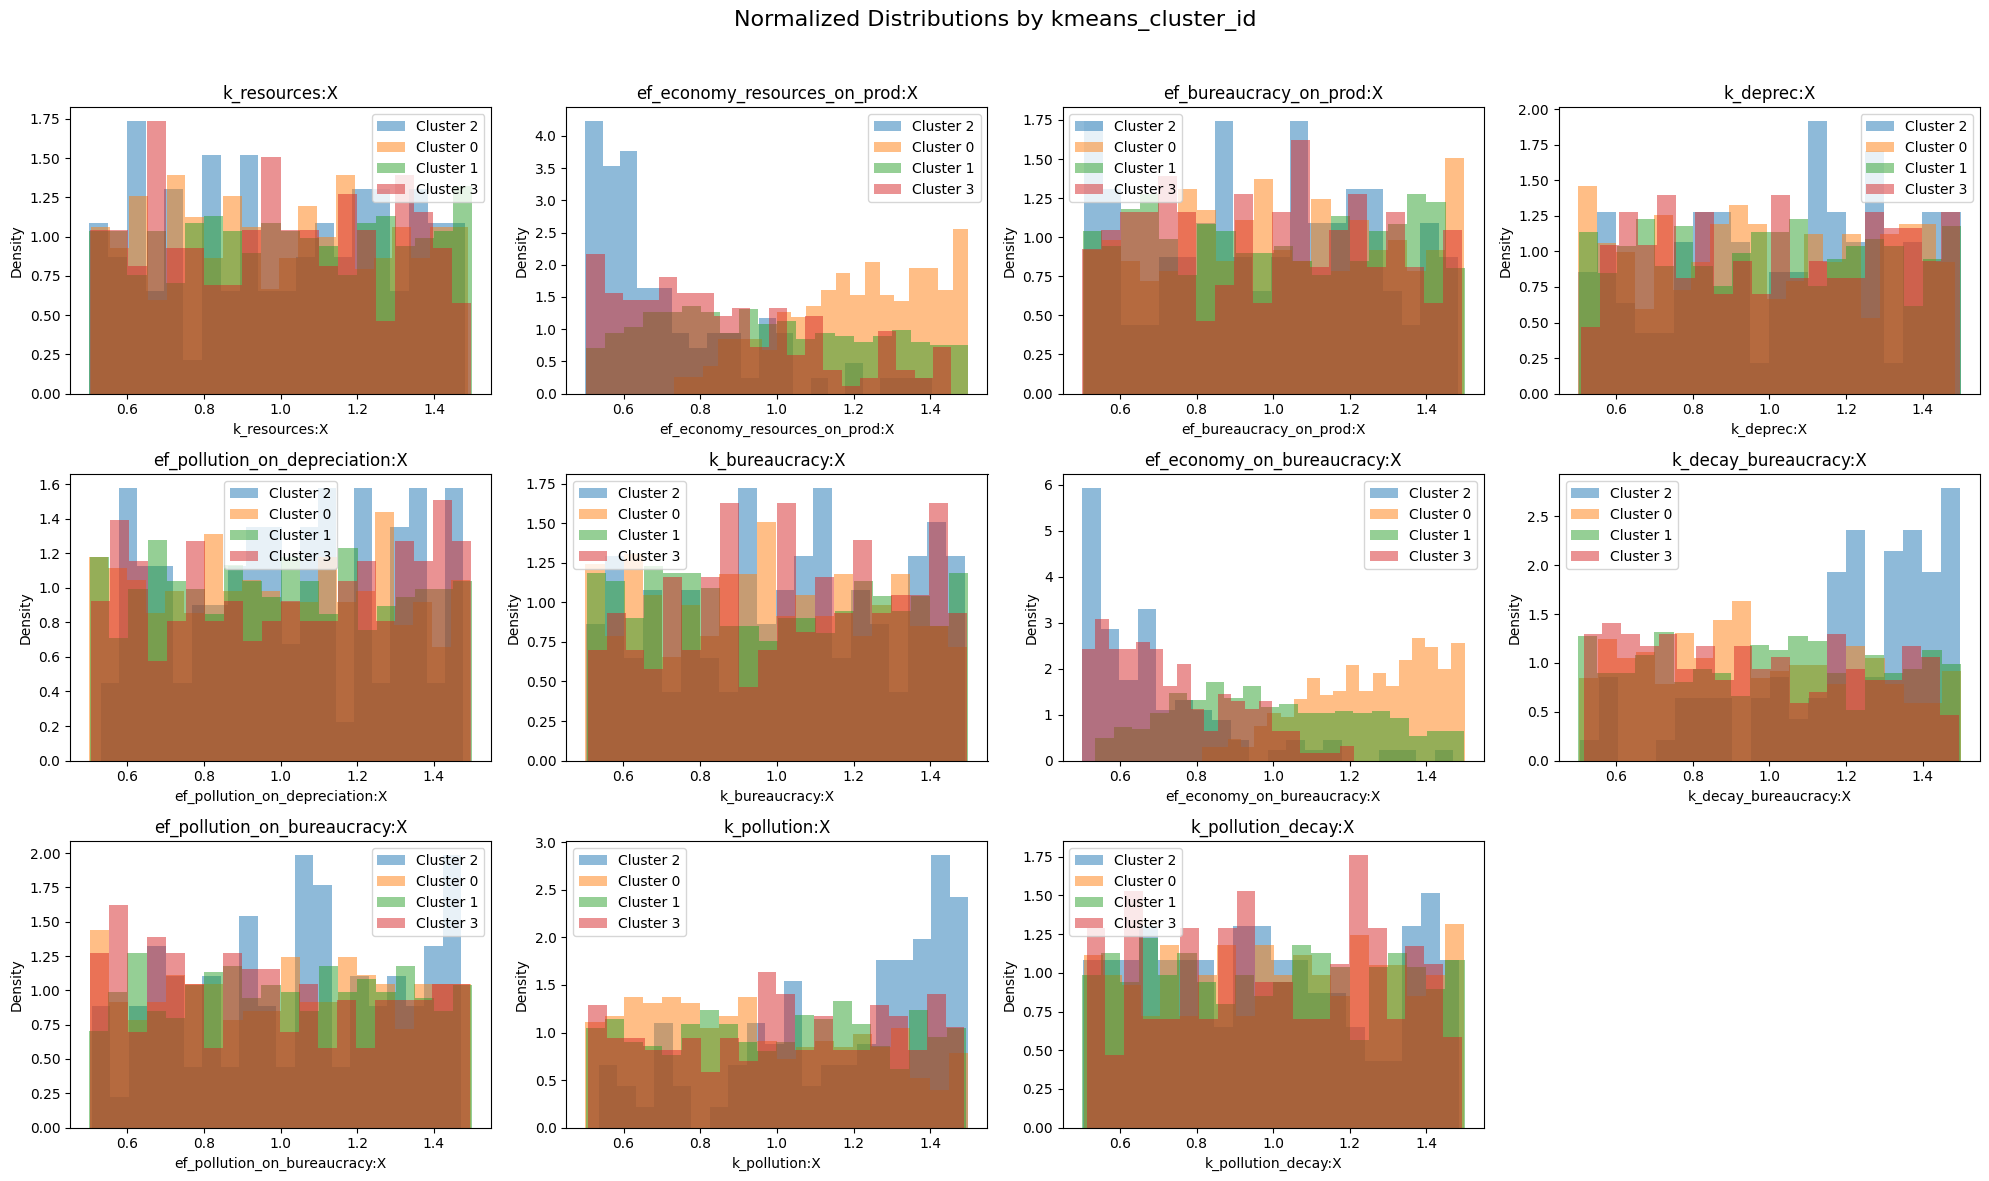

In [165]:
statsu.plot_distribution_by_cluster(exp_design_df, 'kmeans_cluster_id', density=True)

In [166]:
conf = 0.95
ci_df = statsu.compute_confidence_intervals(exp_design_df,
                                    'kmeans_cluster_id',
                                    conf)

ci_df.head()

,kmeans_cluster_id,variable,mean,lower_ci,upper_ci,n
0,0,k_resources:X,0.992610,0.960567,1.024653,307
1,0,ef_economy_resources_on_prod:X,1.210462,1.188948,1.231975,307
2,0,ef_bureaucracy_on_prod:X,1.013236,0.981031,1.045440,307
3,0,k_deprec:X,0.986935,0.954440,1.019429,307
4,0,ef_pollution_on_depreciation:X,0.986200,0.953954,1.018446,307


In [167]:
# Lists of parameters per flow
resource_inflow = ['k_resources:X']
extractive_pollution = ["k_pollution:X"]
production = ["ef_economy_resources_on_prod:X"]
depreciation = ["k_deprec:X"]
bureaucracy_creation = ["ef_economy_on_bureaucracy:X"]
bureaucracy_decay = ["k_decay_bureaucracy:X"]
pollution_abatement = ["k_pollution_decay:X"]


# Join the flow lists into a single list
resources_params = resource_inflow + production + extractive_pollution
economy_params = production + depreciation + bureaucracy_creation
bureaucracy_params = bureaucracy_creation + bureaucracy_decay
poluttion_params = depreciation + bureaucracy_decay + extractive_pollution + pollution_abatement

print(f"Resources params: {resources_params}")
print(f"Economy params: {economy_params}")
print(f"Bureaucracy params: {bureaucracy_params}")
print(f"Pollution params: {poluttion_params}")

Resources params: ['k_resources:X', 'ef_economy_resources_on_prod:X', 'k_pollution:X']
Economy params: ['ef_economy_resources_on_prod:X', 'k_deprec:X', 'ef_economy_on_bureaucracy:X']
Bureaucracy params: ['ef_economy_on_bureaucracy:X', 'k_decay_bureaucracy:X']
Pollution params: ['k_deprec:X', 'k_decay_bureaucracy:X', 'k_pollution:X', 'k_pollution_decay:X']


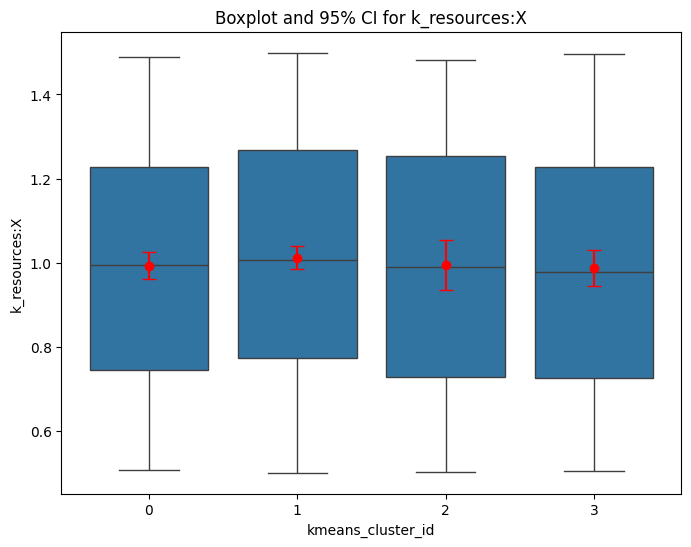

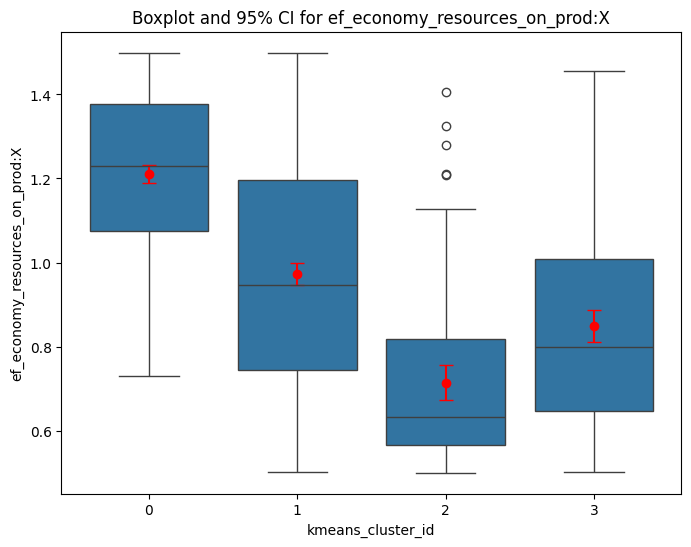

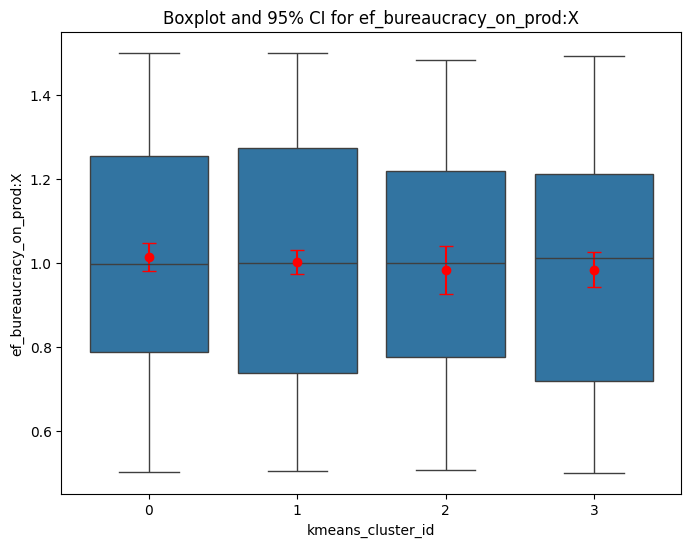

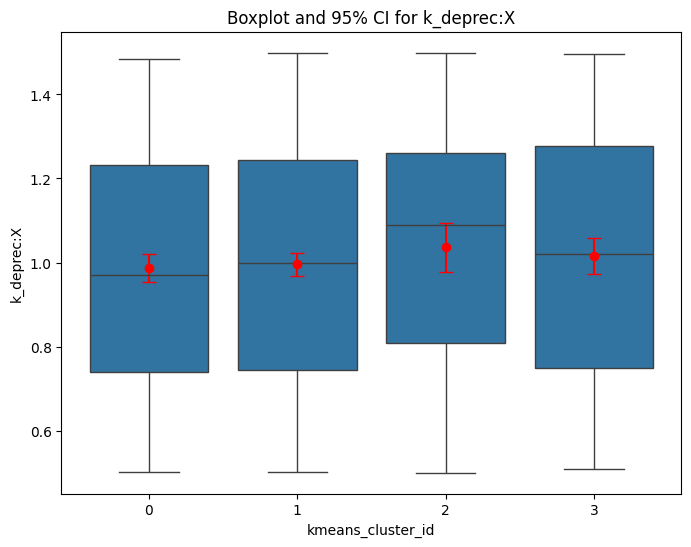

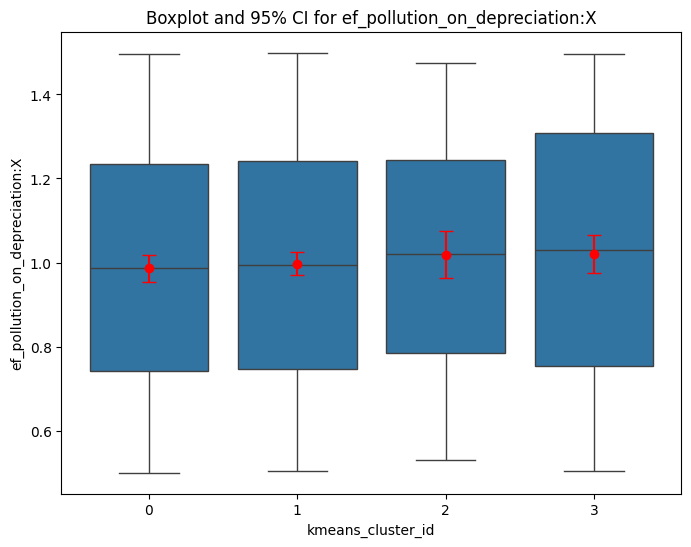

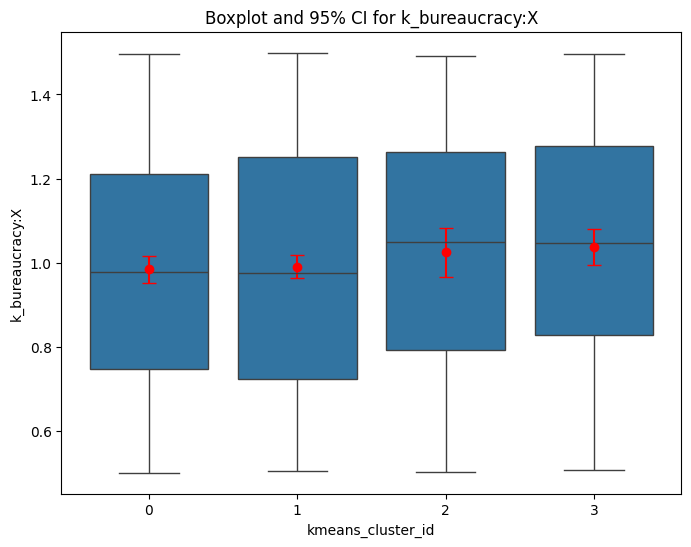

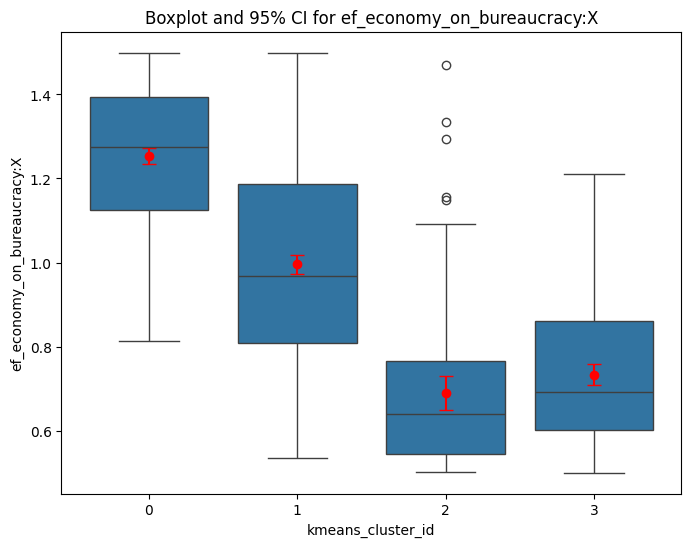

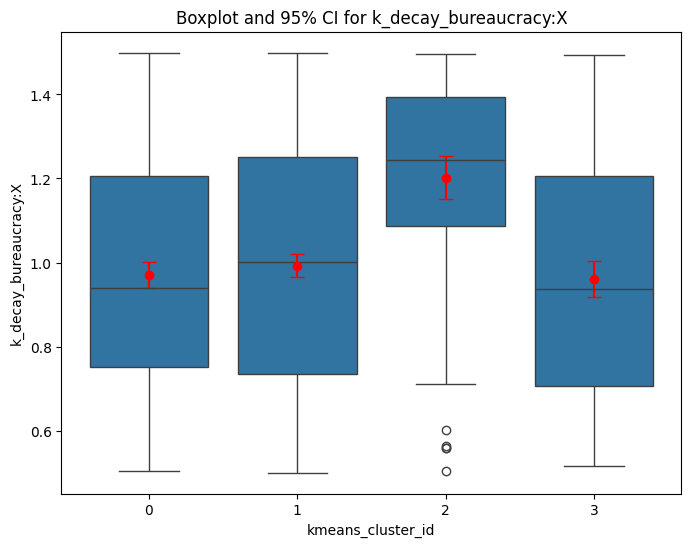

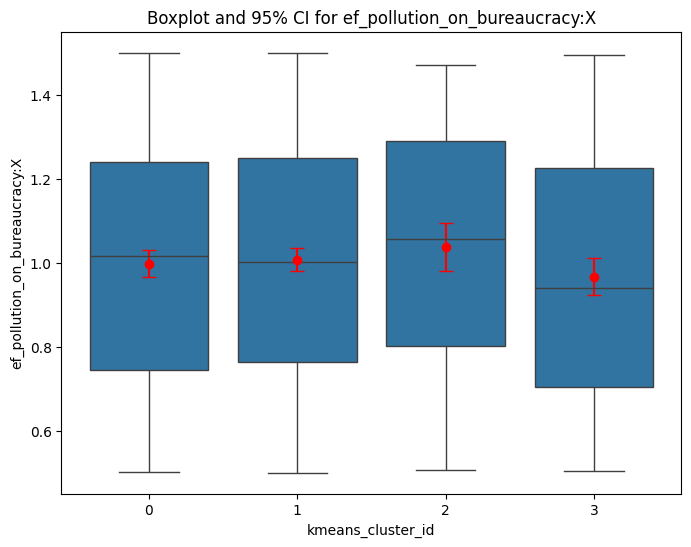

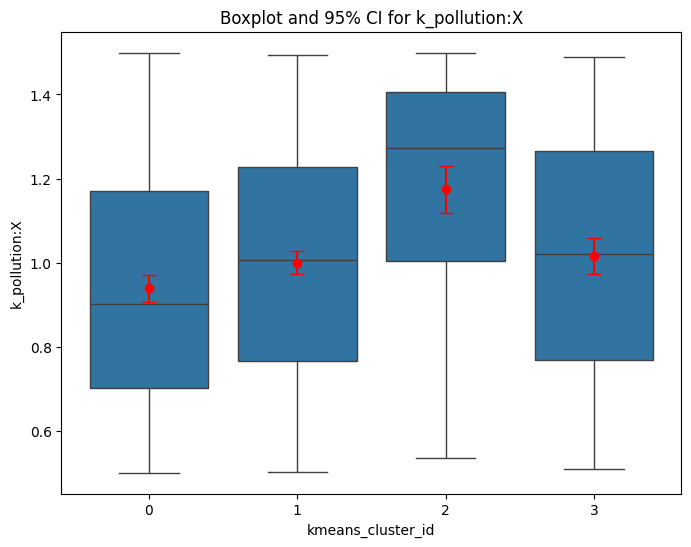

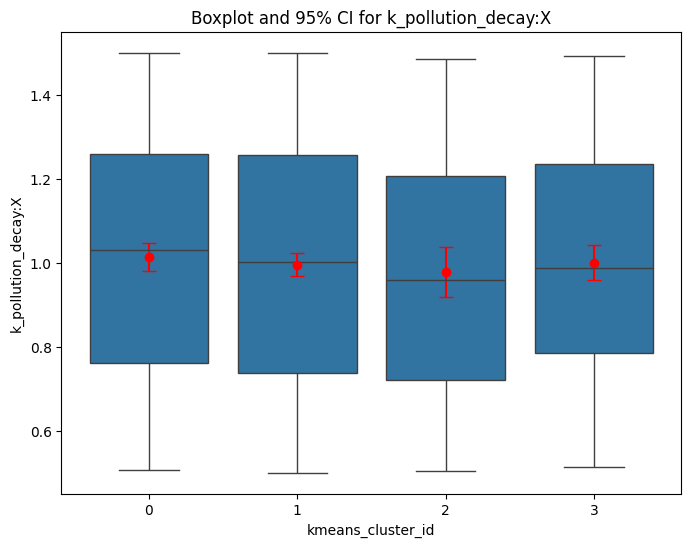

In [168]:
# Plot the confidence intervals
for variable in ci_df['variable'].unique():
    statsu.plot_boxplot_with_error_bar(exp_design_df, ci_df, variable, 'kmeans_cluster_id', conf)

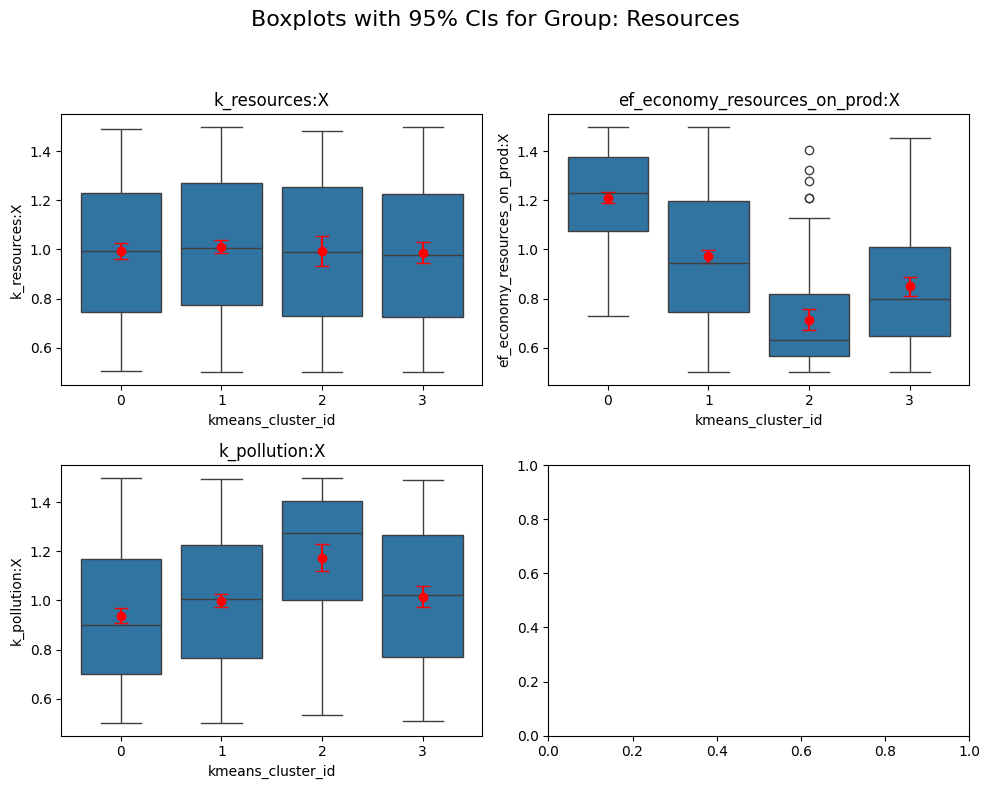

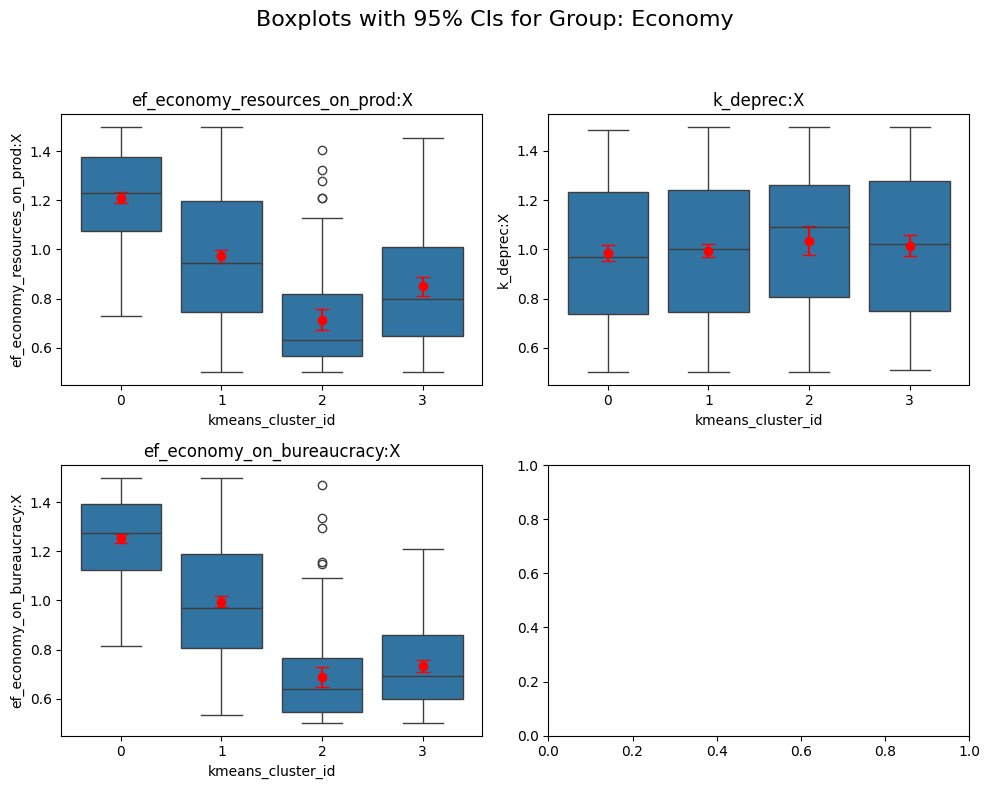

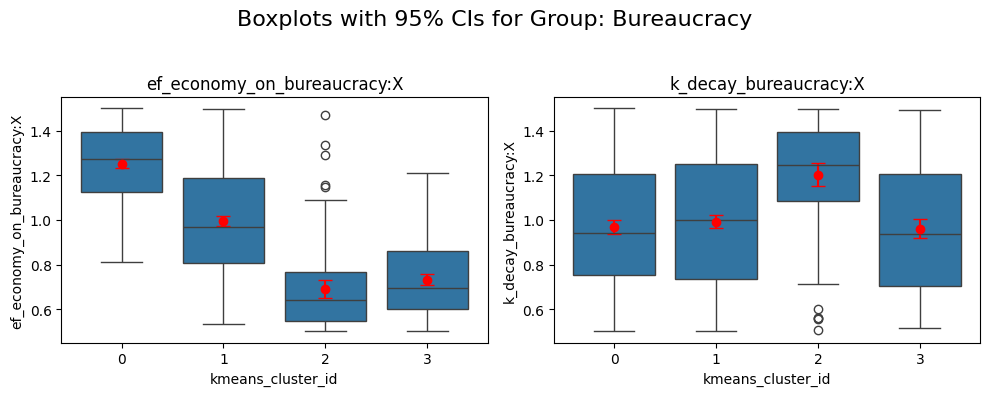

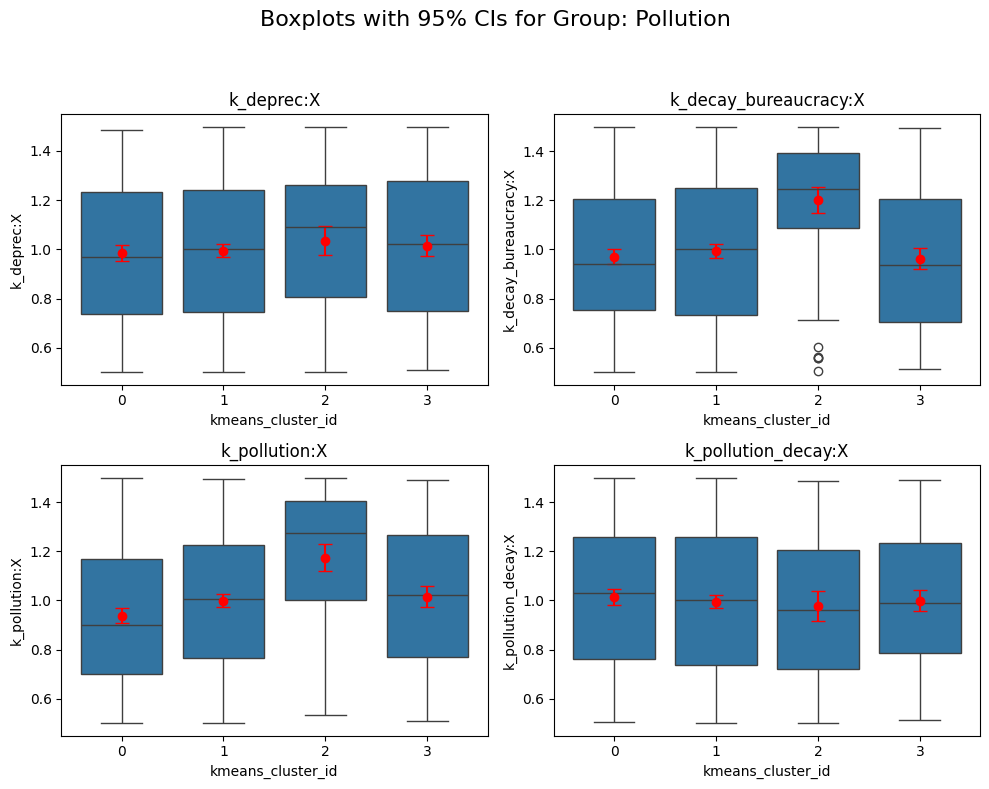

In [169]:
var_groups = {
    'resources': resources_params,
    'economy': economy_params,
    'bureaucracy': bureaucracy_params,
    'pollution': poluttion_params
}
# Plot the confidence intervals for each group
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['resources'], 'kmeans_cluster_id', 'Resources', conf)
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['economy'], 'kmeans_cluster_id', 'Economy', conf)
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['bureaucracy'], 'kmeans_cluster_id', 'Bureaucracy', conf)
statsu.plot_single_group_boxplots_with_error_bars(exp_design_df, ci_df, var_groups['pollution'], 'kmeans_cluster_id', 'Pollution', conf)

In [170]:
def get_summary_stats_from_exp_design(df, clustering_type='kmeans'):
    """
    Get summary stats from the experimental design data frame.
    
    Parameters:
      df (DataFrame): Input experimental design data frame.
      clustering_type (str): Type of clustering to use ('kmeans' or 'dbscan').
      
    Returns:
      DataFrame: Summary statistics with explicit column names.
    """
    # Drop run id column
    df = df.drop(columns=['run_id'])
    
    # Drop the cluster_id column not relevant to the chosen clustering type
    if clustering_type == 'kmeans':
        df = df.drop(columns=['dbscan_cluster_id'])
    elif clustering_type == 'dbscan':
        df = df.drop(columns=['kmeans_cluster_id'])
    
    # Define the aggregation functions with explicit names using the new named aggregation syntax.
    # Here we aggregate all columns (except the clustering column) with the same set of stats.
    agg_funcs = {
        'mean': 'mean',
        'median': 'median',
        'max': 'max',
        'min': 'min',
        'q1': lambda x: x.quantile(0.25),
        'q3': lambda x: x.quantile(0.75),
        'iqr': lambda x: x.quantile(0.75) - x.quantile(0.25)
    }
    
    # Identify the value columns to aggregate (all columns except the grouping column)
    group_col = f'{clustering_type}_cluster_id'
    value_columns = [col for col in df.columns if col != group_col]
    
    # Use the named aggregation feature. Since the aggregation is the same for every column,
    # we build a dictionary comprehension to apply each aggregation to every value column.
    summary_stats_df = df.groupby(group_col)[value_columns].agg(**{
        f"{col}_{stat_name}": (col, func)
        for col in value_columns
        for stat_name, func in agg_funcs.items()
    }).reset_index()
    
    return summary_stats_df


In [171]:
get_summary_stats_from_exp_design(exp_design_df)

,kmeans_cluster_id,k_resources:X_mean,k_resources:X_median,k_resources:X_max,k_resources:X_min,k_resources:X_q1,k_resources:X_q3,k_resources:X_iqr,ef_economy_resources_on_prod:X_mean,ef_economy_resources_on_prod:X_median,...,k_pollution:X_q1,k_pollution:X_q3,k_pollution:X_iqr,k_pollution_decay:X_mean,k_pollution_decay:X_median,k_pollution_decay:X_max,k_pollution_decay:X_min,k_pollution_decay:X_q1,k_pollution_decay:X_q3,k_pollution_decay:X_iqr
0,0,0.992610,0.995325,1.488149,0.506170,0.745668,1.228290,0.482623,1.210462,1.229887,...,0.702559,1.169945,0.467386,1.013760,1.030962,1.498152,0.505517,0.761344,1.258786,0.497443
1,1,1.011886,1.006694,1.499492,0.500803,0.773103,1.268549,0.495446,0.972693,0.946112,...,0.766533,1.227576,0.461042,0.995394,1.001576,1.499977,0.500178,0.737141,1.256821,0.519680
2,2,0.994398,0.990499,1.481590,0.501088,0.727872,1.254478,0.526607,0.714278,0.631540,...,1.003305,1.404999,0.401695,0.977172,0.959225,1.484885,0.502935,0.721312,1.205423,0.484111
3,3,0.987076,0.978895,1.496204,0.503442,0.725370,1.226957,0.501588,0.849702,0.799242,...,0.768200,1.264944,0.496744,0.999337,0.987858,1.491875,0.513168,0.785305,1.235852,0.450546


## Visualize Clustered Time Series

In [172]:
def plot_time_series_by_variable(df: pd.DataFrame, clustering_type: str, column_to_plot: str):
    """
    Plots the time series of a specified column for each run_id,
    coloring each line according to its cluster_id.

    Parameters:
    - df: pd.DataFrame containing 'time', 'run_id', 'cluster_id', and the target column.
    - column_to_plot: str, the name of the column to plot over time.
    """
    # Get unique clusters and assign each a color
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    # Create plot
    plt.figure(figsize=(12, 6))
    for run_id, run_df in df.groupby('run_id'):
        cluster_id = run_df[clustering_type].iloc[0]
        color = cluster_colors[cluster_id]
        plt.plot(run_df['time'], run_df[column_to_plot], alpha=0.5, color=color, label=f'Cluster {cluster_id}' if f'Cluster {cluster_id}' not in plt.gca().get_legend_handles_labels()[1] else "")

    plt.xlabel('Time')
    plt.ylabel(column_to_plot)
    plt.title(f'{column_to_plot} over Time by Run (colored by Cluster ID)')
    plt.legend(title='Cluster ID', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [173]:
def plot_all_variables_subplots(df: pd.DataFrame, clustering_type: str):
    """
    Creates a 2x2 grid of subplots for the columns 'Resources', 'Economy', 'Bureaucracy', and 'Pollution',
    plotting time series for each run_id and coloring lines by cluster_id.
    """
    columns_to_plot = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']
    clusters = df[clustering_type].unique()
    cluster_colors = {cluster: plt.cm.tab10(i % 10) for i, cluster in enumerate(clusters)}

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for i, column in enumerate(columns_to_plot):
        ax = axes[i]
        for run_id, run_df in df.groupby('run_id'):
            cluster_id = run_df[clustering_type].iloc[0]
            color = cluster_colors[cluster_id]
            ax.plot(run_df['time'], run_df[column], color=color)

        ax.set_title(f'{column} over Time')
        ax.set_xlabel('Time')
        ax.set_ylabel(column)
        ax.grid(True)

    # Shared legend
    handles = [plt.Line2D([0], [0], color=cluster_colors[c], label=f'Cluster {c}') for c in clusters]
    fig.legend(handles=handles, title='Cluster ID', loc='upper center', ncol=len(clusters), bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [174]:
def plot_all_clusters(df: pd.DataFrame, clustering_type: str):
    """
    Creates a grid of subplots where each subplot corresponds to a unique cluster (based on `clustering_type`).
    In each subplot, all time series for the stock variables 'Resources', 'Economy', 'Bureaucracy', and 'Pollution'
    are plotted for the runs belonging to that cluster.
    
    Parameters:
        df (pd.DataFrame): The input dataframe containing time series data, including a time column ('time'),
                           a unique run identifier ('run_id'), and a clustering column (specified by clustering_type).
        clustering_type (str): The name of the column in df that contains the cluster id for each run.
    """
    # Define the stock variables to plot.
    columns_to_plot = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']
    
    # Extract and sort unique clusters.
    clusters = sorted(df[clustering_type].unique())
    n_clusters = len(clusters)
    
    # Determine grid size using a square-like layout.
    n_cols = math.ceil(math.sqrt(n_clusters))
    n_rows = math.ceil(n_clusters / n_cols)
    
    # Create the subplots with shared axes.
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows),
                             sharex=True, sharey=True)
    # Flatten axes array for easier iteration.
    if n_clusters == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    # Define consistent colors for each variable.
    variable_colors = {
        'Resources': 'blue',
        'Economy': 'orange',
        'Bureaucracy': 'green',
        'Pollution': 'red'
    }
    
    # Loop over clusters to plot the series in each subplot.
    for i, cluster in enumerate(clusters):
        ax = axes[i]
        # Filter dataframe to include only runs from the current cluster.
        df_cluster = df[df[clustering_type] == cluster]
        
        # To avoid duplicate legend entries, track which variable labels have been added.
        labels_plotted = {}
        
        for run_id, run_df in df_cluster.groupby('run_id'):
            for var in columns_to_plot:
                label = None
                # Only add a label once per variable.
                if var not in labels_plotted:
                    label = var
                    labels_plotted[var] = True
                ax.plot(run_df['time'], run_df[var],
                        color=variable_colors[var],
                        label=label,
                        alpha=0.7)
        
        ax.set_title(f"Cluster {cluster}")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        ax.legend()
    
    # Hide any unused subplots if the grid is larger than the number of clusters.
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # Enable tick labels for all subplots.
    for ax in axes:
        ax.tick_params(axis='both', labelbottom=True, labelleft=True)
    
    plt.tight_layout()
    plt.show()


In [175]:
def plot_time_series_by_cluster_subplots(df: pd.DataFrame, clustering_type: str, column_to_plot: str):
    """
    Plots time series for each cluster in separate subplots.
    Each subplot contains the time series of all run_ids in that cluster for the selected column,
    and all lines in a subplot share the same color.

    Parameters:
    - df: pd.DataFrame containing the data.
    - column_to_plot: str, the name of the column to plot.
    - title: str, optional, the title for the entire figure.
    """
    clusters = sorted(df[clustering_type].unique())
    n_clusters = len(clusters)
    n_cols = 2
    n_rows = math.ceil(n_clusters / n_cols)

    # Assign a consistent color per cluster using the updated get_cmap
    colormap = plt.get_cmap('tab10', n_clusters)
    cluster_colors = {cluster_id: colormap(i) for i, cluster_id in enumerate(clusters)}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), squeeze=False)
    axes = axes.flatten()

    for i, cluster_id in enumerate(clusters):
        ax = axes[i]
        color = cluster_colors[cluster_id]
        cluster_df = df[df[clustering_type] == cluster_id]

        for run_id, run_df in cluster_df.groupby('run_id'):
            ax.plot(run_df['time'], run_df[column_to_plot], color=color, alpha=0.9)

        ax.set_title(f'Cluster {cluster_id}')
        ax.set_xlabel('Time')
        ax.set_ylabel(column_to_plot)
        ax.grid(True)

    # Hide any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Set the title for the entire figure
    fig.suptitle(f'{column_to_plot} Clusters', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make space for the title
    plt.show()


In [176]:
state_variables = ['Resources', 'Economy', 'Bureaucracy', 'Pollution']

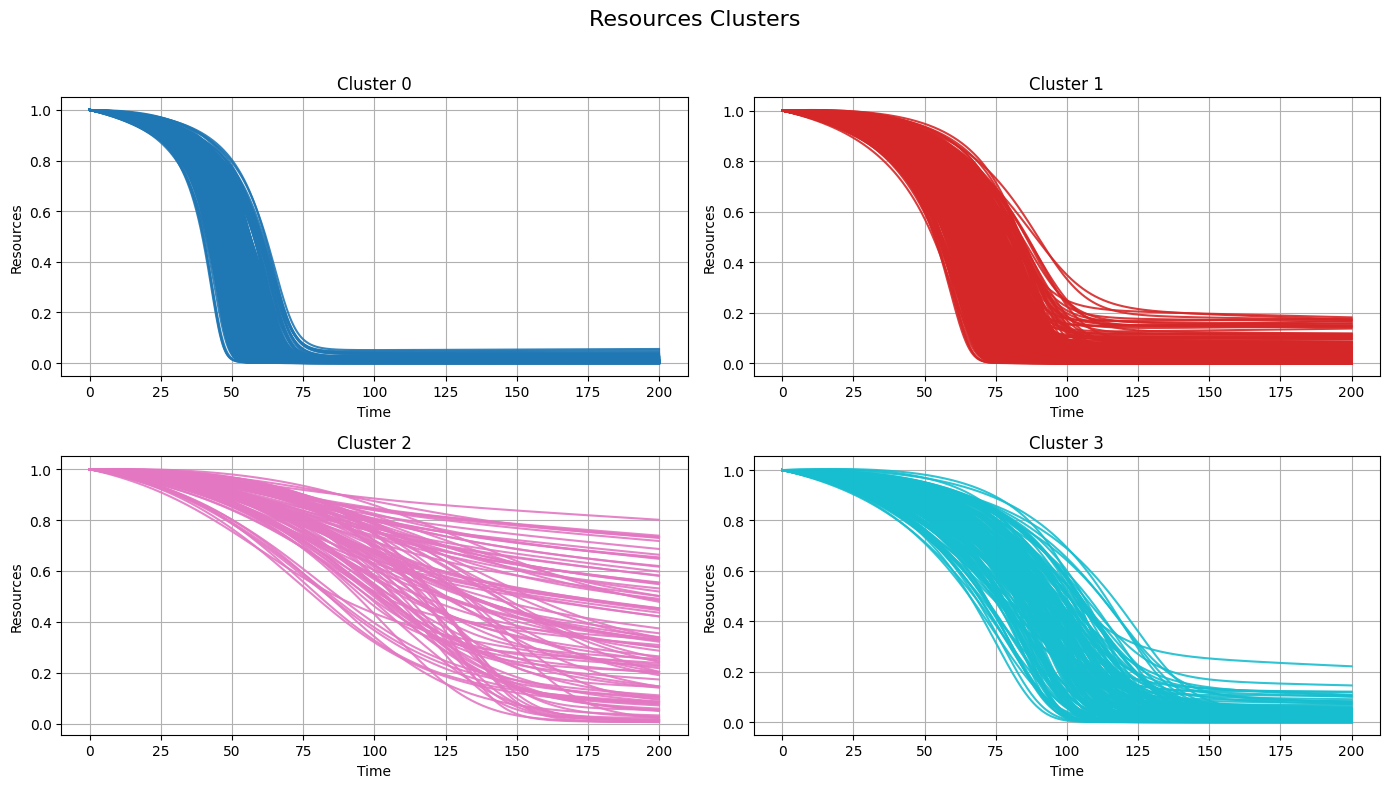

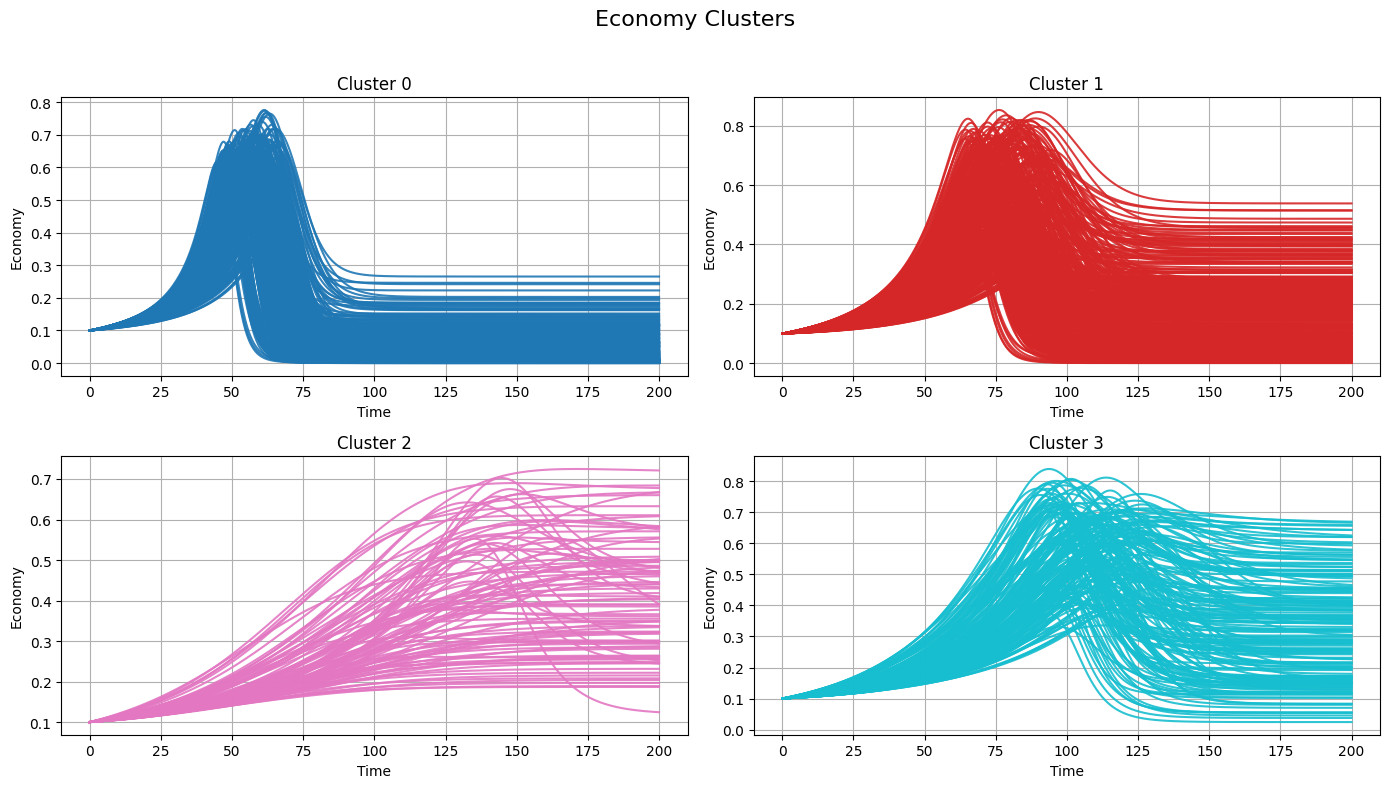

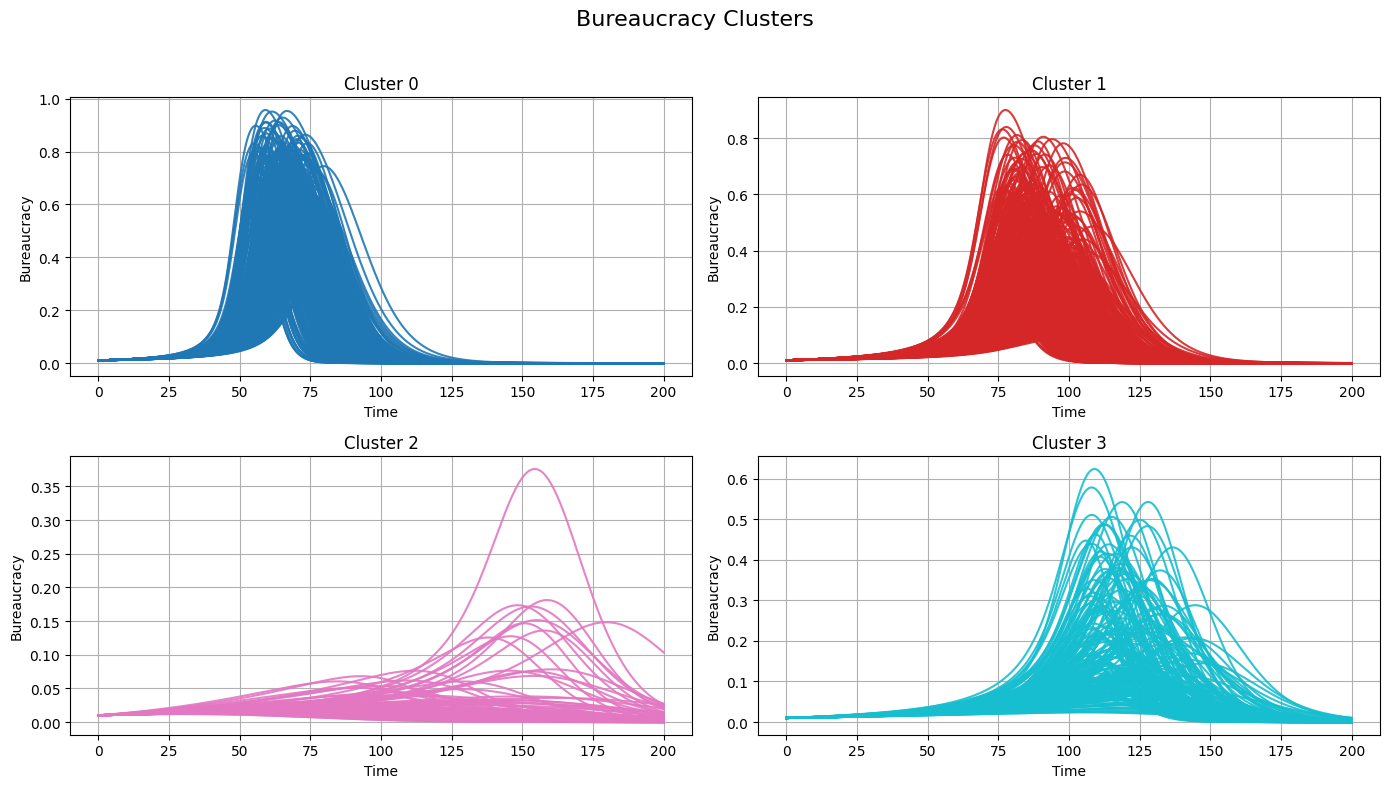

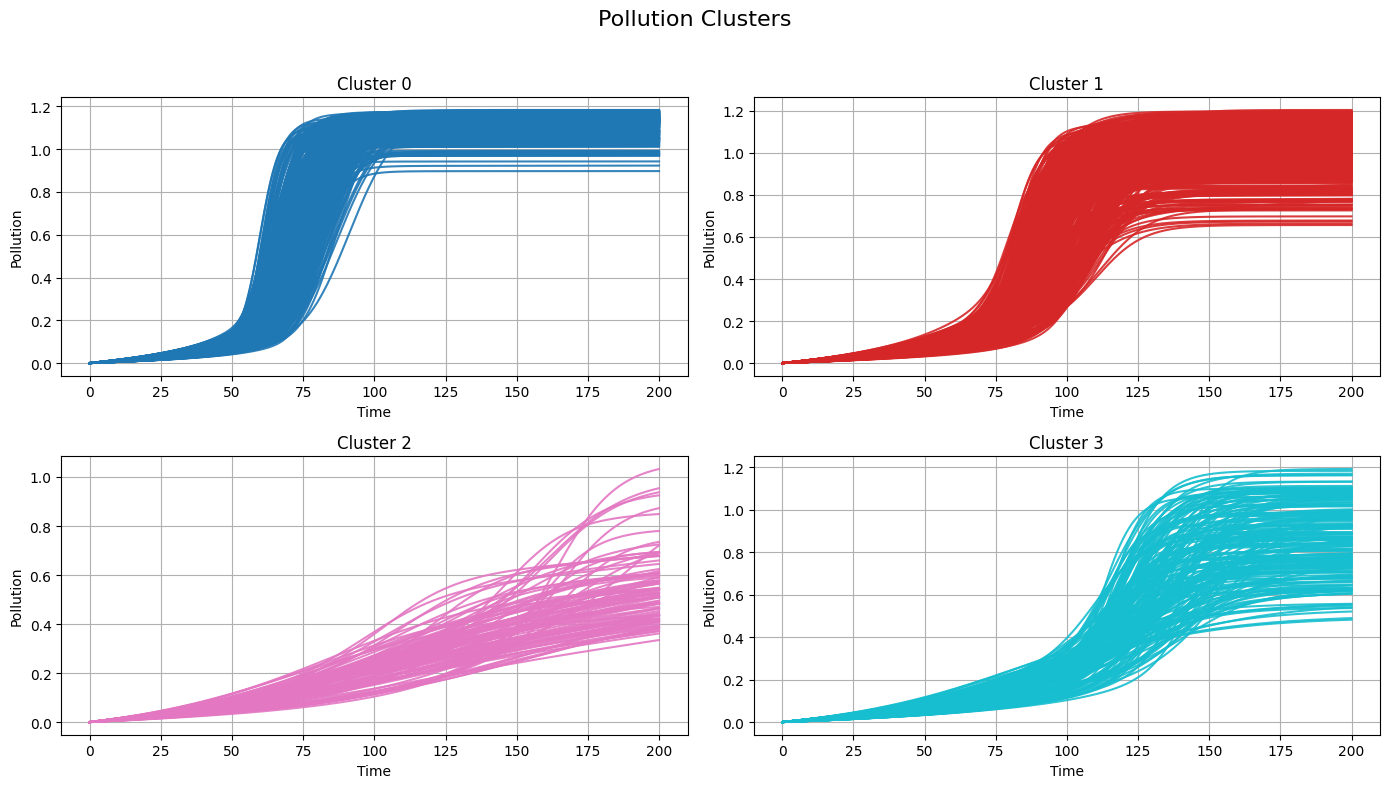

In [177]:
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy')
plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution')

In [178]:
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Resources')
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Economy')
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Bureaucracy')
# plot_time_series_by_cluster_subplots(labeled_scenarios_df, 'dbscan_cluster_id', 'Pollution')

In [179]:
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Resources')
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Economy')
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Bureaucracy')
# plot_time_series_by_variable(labeled_scenarios_df, 'kmeans_cluster_id', 'Pollution')

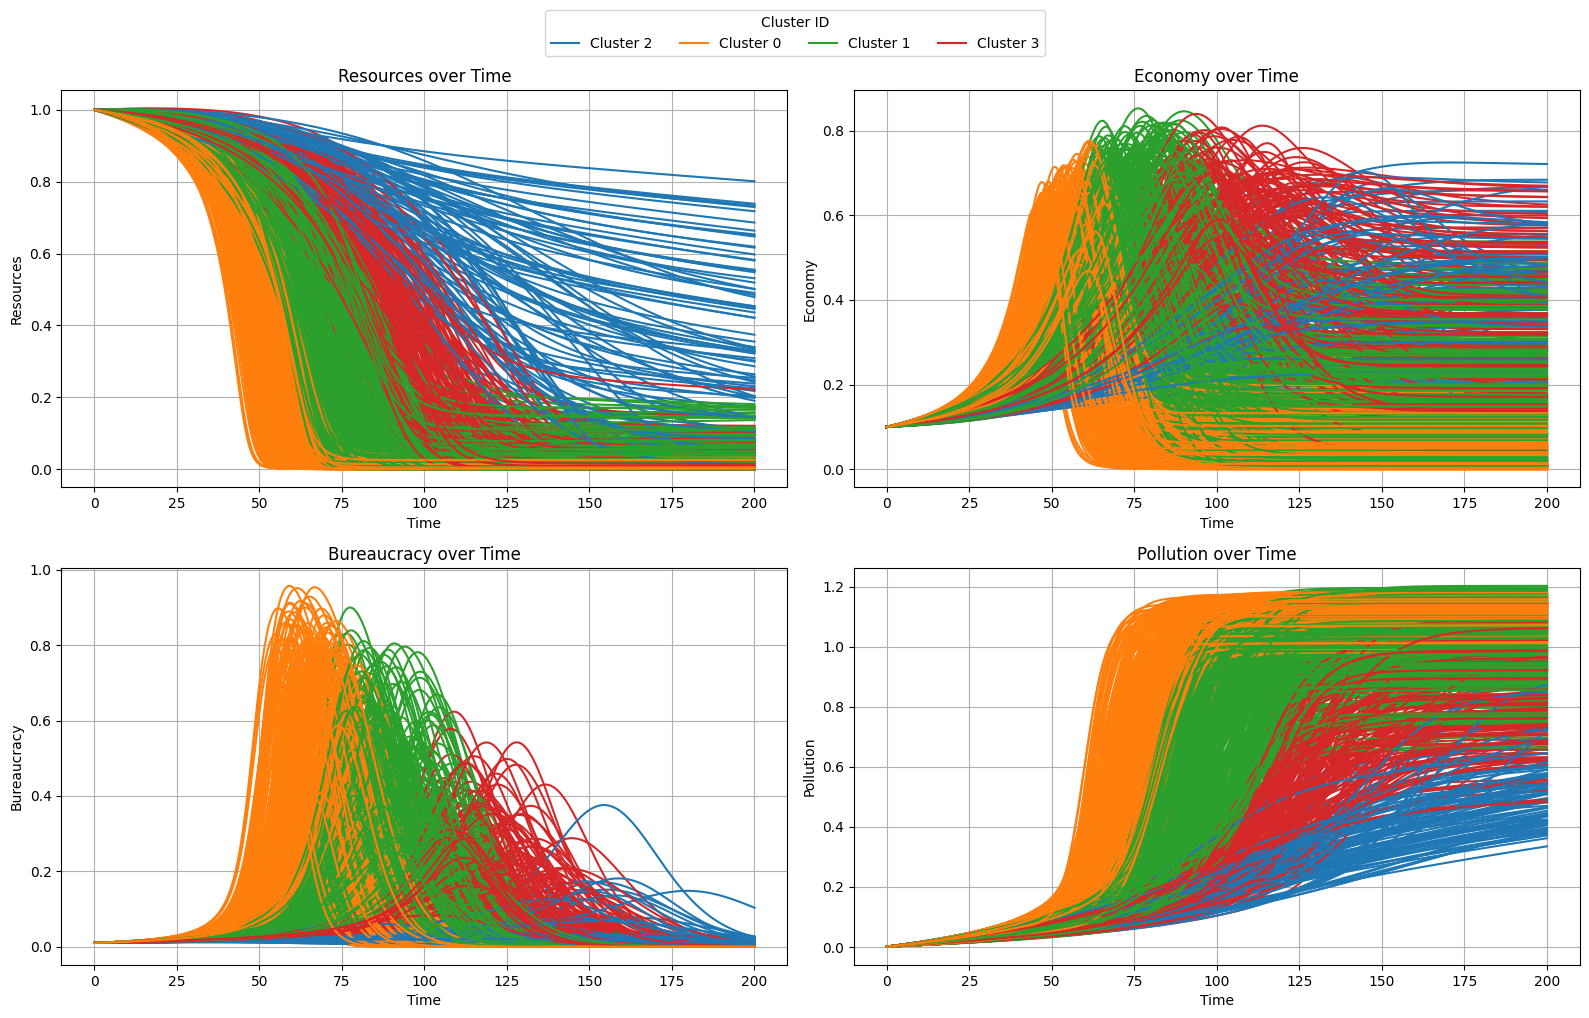

In [180]:
plot_all_variables_subplots(labeled_scenarios_df, 'kmeans_cluster_id')

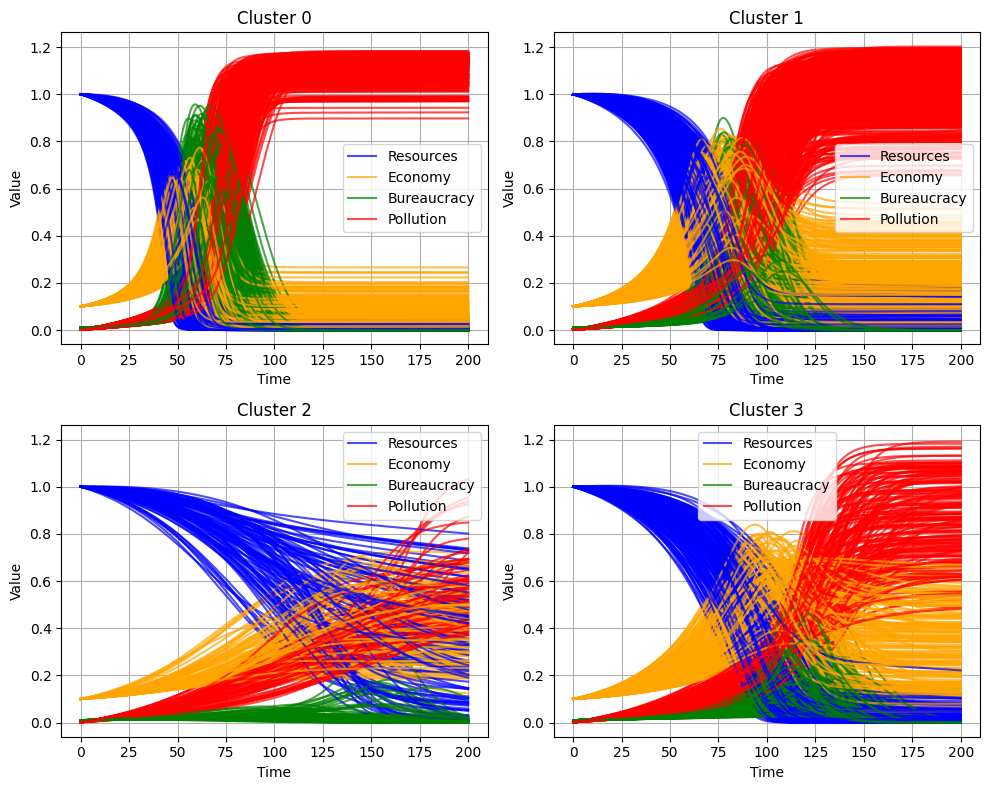

In [181]:
plot_all_clusters(labeled_scenarios_df, 'kmeans_cluster_id')

In [182]:
# plot_all_clusters(labeled_scenarios_df, 'dbscan_cluster_id')